# Tronos Analysis
## Introduction
Welcome to Tronos Analysis. In this notebook, group analysis of chromosome trajectories is possible. There are two types of cells; _markdown_ cells such as this, with text content containing explanations about the analysis methodology and interpretation of results, and _code_ cells, which contains the snippets that may be executed with your own data.

Refer to the latest up-to-date Notebooks at https://github.com/danilexn/tronos
Please, cite this work when using the Tronos workflow

## Configuring parameters
In the following cell, you may want to configure some settings that will be used throughout the rest of the analysis, such as Pixel Sizel, Moving Average smoothing order, the sampling time in seconds and the subtitles for most of the plots. Required packages for the notebook will be also installed at this point.

In [1]:
pixel.size <- 0.066 # Microns (indicate 1 if already set in source file)
ma.order <- 12
sampling.time <- 60 # Seconds
spectrum.plot.subtitle <- "AFA226 (wt) vs. AFA851 (pht1D)"
folder.route <- "."

In [2]:
# Load libraries

# If spdep package cannot be installed, please uncomment the following and run the cell
#    install.packages("remotes")
#    remotes::install_cran(c("sp", "rgdal", "units"), force = TRUE)

packages <- c(
                "spdep", 
                "forecast", 
                "dplyr", 
                "ggplot2", 
                "segclust2d", 
                "dplR", 
                "tsmp", 
                "mclust", 
                "lmtest",
                "purrr",
                "tidyr",
                "reshape2",
                "tseries"
             )

package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

Loading required package: spdep

Loading required package: sp

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: sf

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: segclust2d

Loading required package: dplR

Loading required package: tsmp

Welcome to Matrix Profile


Attaching package: ‘tsmp’


The following object is masked from ‘package:dplyr’:

    compute


The following object is 

## Loading data
The folder that you previously gave as parameter is going to be explored for CSV files.
Please, make sure that data in CSV files complies the Tronos-output format, having the following columns (any order is possible):

_frame, y, x, minor, major, area, convexity, perimeter, circularity,particle,label_

The time variable is specified after the df\\$times <- [], where [] is the variable in df\\$variable format that represents time, in seconds. Please, re-scale your variable to represent seconds. It is also possible to filter out unwanted cell types or features from your analysis: please, modify the cell below to adjust the data, following dplyr syntax as in the rest of the notebook.

You may also specify a timepoint 0 different from frame 1 with feature-linking. Please, refer to the instructions in https://github.com/danilexn/tronos

In [3]:
setwd(folder.route)
file.names <- dir(folder.route, pattern="sample_data.csv")
df <- do.call(rbind,lapply(file.names,read.csv))
if (length(df) < 1){
    stop("Data could not be loaded!")
}

## Specifying which is time
df$times <- df$frame

## Re-scale variables
df$x <- (df$x - min(df$x))*pixel.size
df$y <- (df$y - min(df$y))*pixel.size
df[,c("minor","major")] <- df[,c("minor","major")]*pixel.size
df$area <- df$area*pixel.size*pixel.size
df$radius <- sqrt(df$area/3.14)

## Rotating cell coordinates
As cells may be oriented in different angles, a critical step of oscillation analysis is to homogeneize axis across them, making measures comparable. In the following cell, _best rotation_ is calculated to make the Y axis the greatest varying, and X the least varying. If you do not execute this cell, please consider that trajectory is going to be extracted from the Y axis, anyway.

In [4]:
homogeneize.rotation <- function(x, y){
    
    coords <- cbind(X = x, Y = y)
    rad <- seq(0, pi, l=20)
    opar <- par(mfrow=c(5,4), mar=c(3,3,1,1))
    best.rotation <- c()
    for(i in rad){
        coords.rot <- Rotation(coords, i)
        best.rotation <- c(best.rotation, abs(max(coords.rot[,1])-min(coords.rot[,1])))
    }

    rot <- rad[which.min(best.rotation)]
    coords.rot <- Rotation(coords, rot)
    return(coords.rot)
}

df <- df %>% group_by(particle) %>% 
  mutate(x = homogeneize.rotation(x, y)[,1], y = homogeneize.rotation(x, y)[,2]) %>%
  complete(frame.1 = seq(min(frame.1), max(frame.1))) %>%
  mutate(frame = frame.1)

## Displaying cell trajectories
After trajectory rotation, you may sight the trajectories for each particle, in each strain, with respect to time, in the relative position, normalized to pixel size.

Saving 6.67 x 6.67 in image



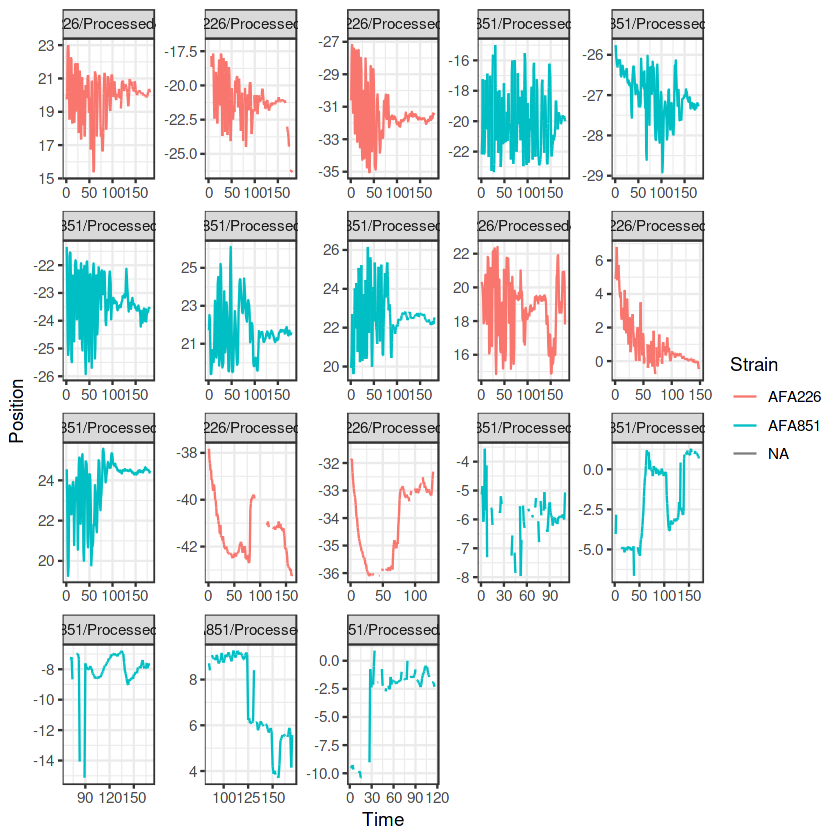

In [5]:
p.trajectories <- ggplot(data = df,
  mapping = aes(x = frame.1, y = y, group = particle, colour = label)) +
  geom_line() +
  facet_wrap(facets = particle ~ .,scales='free') +
  theme_bw() +
  labs(color="Strain", fill="Strain", y = "Position", x = "Time")


p.trajectories
ggsave("trajectories.pdf")

## Sequence spectrum
There are two domains that can be considered in this analysis: time domain, as the change in position over time, and frequency domain, as the richness of frequencies of this behaviour; in summary, frequential-spectral analysis allows to assay the composition of periodicities or frequencies of a given time series, as a measure of how it can be repetitive or oscillatory. Spectral density, represented in the Trajectory periodicity plot below, may present peaks around the frequencies that arise from the change in position over time. As an example, a frequency of 2.7e-03 Hz or a period of around 6 minutes indicates that the trajectory is repetitive in 6 minutes intervals. Presence of various peaks may indicate that there are different periodicities at the same time, or that in the same time series, there is first a dominant frequency, then other dominant frequency (maybe to a conservation in movement amplitude but with different velocity).

`geom_smooth()` using formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



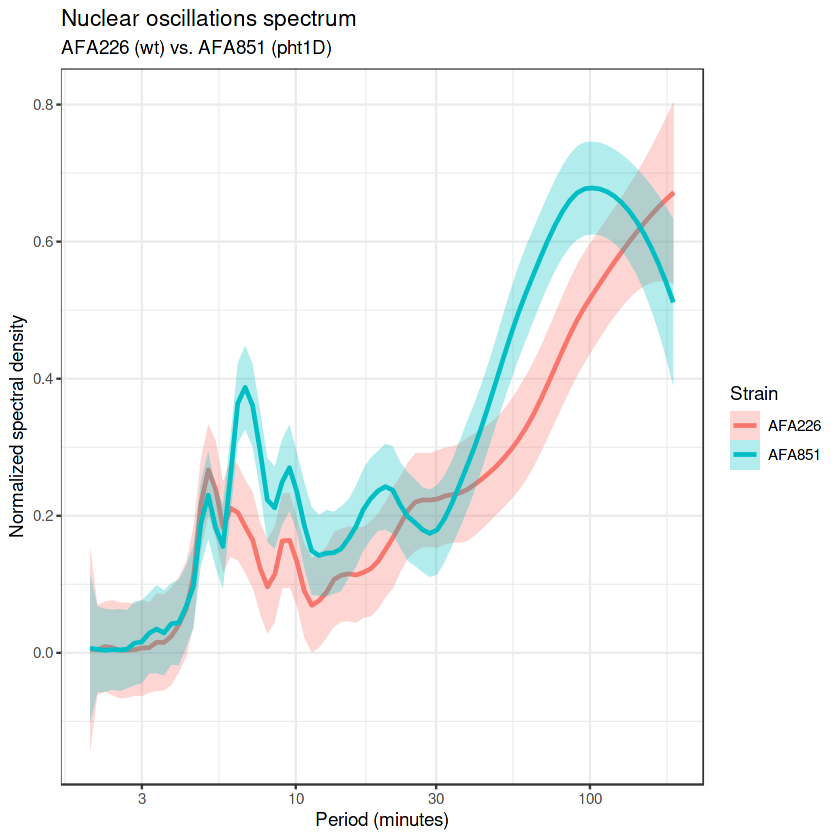

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'



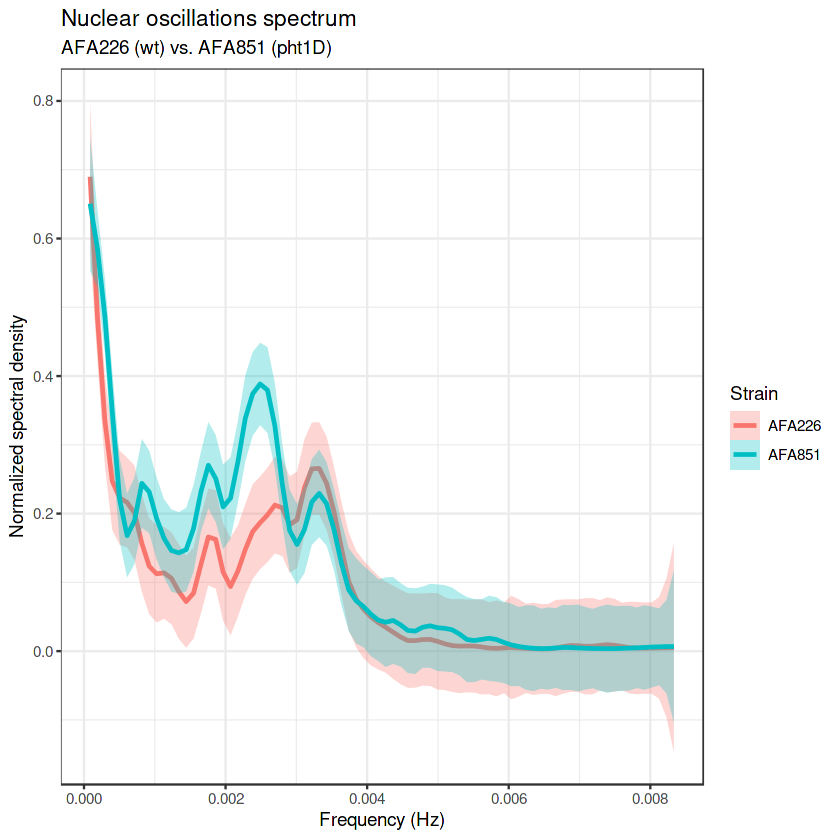

Saving 6.67 x 6.67 in image



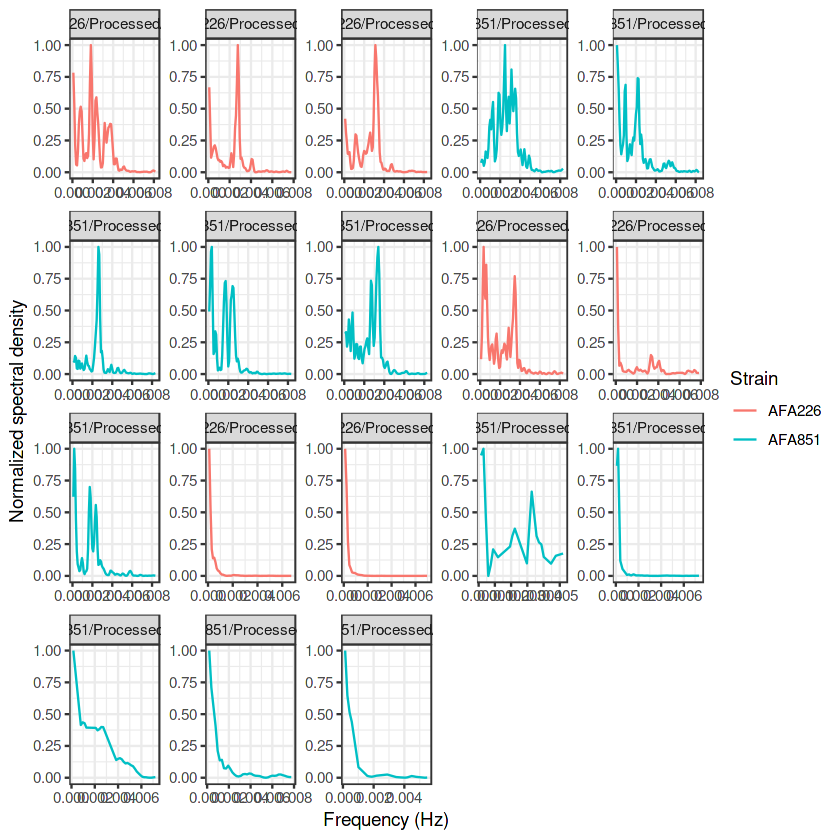

In [6]:
calculate.spectrum <- function(y, frame){
    y.spec <- spectrum(y,log="yes",span=2,plot=FALSE,na.action=na.remove)
    spy <- 2*y.spec$spec
    if (length(y) > length(spy)){
        spy<-spy[1:length(y)]
    }
    return(spy)
}

calculate.freqs <- function(y, frame){
    y.spec <- spectrum(y,log="yes",span=2,plot=FALSE,na.action=na.remove)
    spx <- y.spec$freq/sampling.time
    if (length(y) > length(spx)){
        spx<-spx[1:length(y)]
    }
    return(spx)
}

normalize <- function(x) {
    return((x-min(x))/(max(x)-min(x)))
}

# Generate the dataframe which contains all spectral data

df_freqs <- df %>% group_by(particle) %>% 
            mutate(spec.s = calculate.spectrum(y, frame), spec.f = calculate.freqs(y, frame)) %>%
            na.omit() %>% mutate(spec.s = normalize(spec.s))

# Generate plots

p.period <- ggplot(df_freqs, aes((1/spec.f)/60, spec.s), colour=label) +
  ggtitle(label = "Nuclear oscillations spectrum", subtitle = spectrum.plot.subtitle) +
  stat_smooth(method="loess", span=0.1, se=TRUE, aes(color = label, fill = label), alpha=0.3) +
  theme_bw() +
  labs(color="Strain", fill="Strain") +
  ylab("Normalized spectral density") + 
  scale_x_continuous(trans = "log10") +
  xlab("Period (minutes)")

p.freq <- ggplot(df_freqs, aes(spec.f, spec.s), colour=label) +
  ggtitle(label = "Nuclear oscillations spectrum", subtitle = spectrum.plot.subtitle) +
  stat_smooth(method="loess", span=0.1, se=TRUE, aes(color = label, fill = label), alpha=0.3) +
  labs(color="Strain", fill="Strain") +
  theme_bw() +
  ylab("Normalized spectral density") + 
  xlab("Frequency (Hz)")


p.freq.i <- ggplot(df_freqs,
  mapping = aes(x = spec.f, y = spec.s, group = particle, colour = label)) +
  geom_line() +
  facet_wrap(facets = particle ~ .,scales='free') +
  theme_bw() +
  labs(color="Strain", fill="Strain", y = "Normalized spectral density", x = "Frequency (Hz)")


p.period
ggsave("period_comparison.pdf")
p.freq
ggsave("frequency_comparison.pdf")
p.freq.i
ggsave("frequency_individual.pdf")

## Velocity calculation
Velocity is calculated as the vector modulo, for the X and Y positions specified in the source files. This way, speed is invariant on the previous rotation. A moving average smoothing can also take place: this method allows to reduce extreme peaks or variation in a univariate time series, hence allowing to perform the following analysis more easily (i.e., segmentation analysis).

Warning message:
“Ignoring unknown parameters: trim”


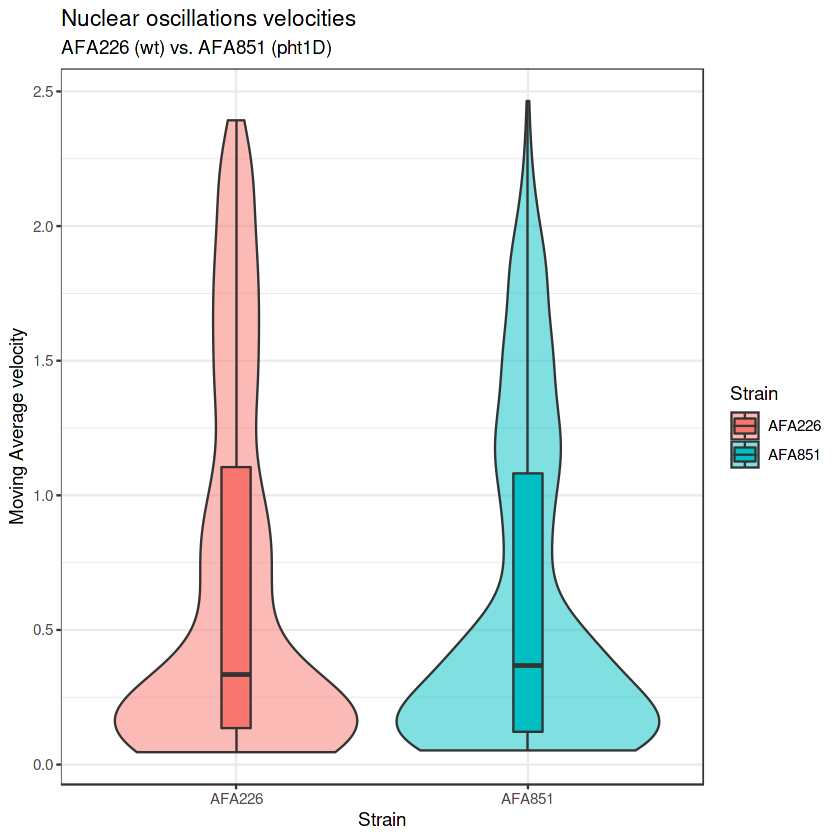

In [7]:
calculate.velocity <- function(y, x){
    vt <- sqrt(diff(y)^2+diff(x)^2)
    if (length(y) > length(vt)){
        vt<-vt[1:length(y)]
    }
    return(vt)
}

calculate.velocity.ma <- function(y, x){
    vt <- sqrt(diff(y)^2+diff(x)^2)
    vt.smooth <- forecast::ma(vt, order = ma.order)
    if (length(y) > length(vt.smooth)){
        vt.smooth<-vt.smooth[1:length(y)]
    }
    return(vt.smooth)
}

df_vt.smooth <- df %>% group_by(particle) %>% 
            mutate(vel.ma = calculate.velocity.ma(y, x)) %>%
            na.omit()

p.vt.smooth <- ggplot(df_vt.smooth, aes(y=vel.ma, fill=label, x = label)) +
    ggtitle(label = "Nuclear oscillations velocities", subtitle = spectrum.plot.subtitle) +
    #geom_histogram(alpha=0.2,aes(y=..density..)) +
    geom_violin(trim=TRUE, alpha = 0.5) +
    geom_boxplot(width=0.1, trim = TRUE, outlier.shape = NA) +
    labs(fill="Strain") +
    theme_bw() +
    xlab("Strain") + 
    ylab("Moving Average velocity")

p.vt.smooth

## Morphologies 
The following plots represent the most interesting morphological descriptors, being convexity, circularity, major axis and minor axis. This way, it can be visualized how different segments can comprise the nuclear oscillations, and how different morphology classes can be considered.

Using label as id variables

Warning message:
“Removed 752 rows containing non-finite values (stat_density).”


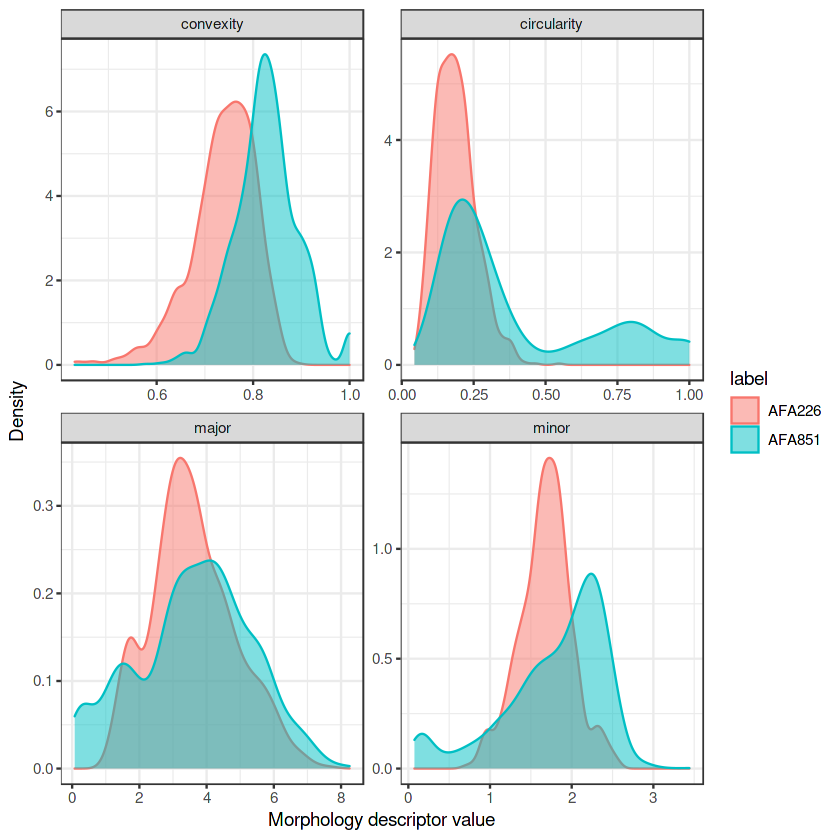

In [8]:
# Distributions for the morphologies

df_morpho <- df[, c("label", "convexity", "circularity", "major", "minor")]
d_long <- melt(df_morpho)

ggplot(d_long, aes(x = value, colour = label, fill = label)) + 
  geom_density(alpha = 0.5) + 
  facet_wrap( ~ variable, scales = "free", ncol = 2) +
  theme_bw() +
  xlab("Morphology descriptor value") + 
  ylab("Density")